# Análise dados CEAPS

CEAPS - Cotas para exercício da atividade parlamentar dos Senadores.
A cota parlamentar é o valor que os membros do Poder Legislativo (deputados federais e estaduais, senadores e vereadores) têm direito a receber para cobrir despesas em função da sua atividade como parlamentar (agente público).

### Importações necessárias

In [165]:
import pandas as pd

#gráficos
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [2]:
df_ceaps19 = pd.read_csv('despesa_ceaps_2019.csv', on_bad_lines='skip', sep = ';', header=1)
df_ceaps20 = pd.read_csv('despesa_ceaps_2020.csv', on_bad_lines='skip', sep = ';', header=1)
df_ceaps21 = pd.read_csv('despesa_ceaps_2021.csv', on_bad_lines='skip', sep = ';', header=1)
df_ceaps22 = pd.read_csv('despesa_ceaps_2022.csv', on_bad_lines='skip', sep = ';', header=1)

apesar de não ter a informação do estado, partido e se está ativo ou não na base original da CEAPS, resolvi trazer essas informações, pois acredito que podem agregar.

In [3]:
df_sendores_uf_partido = pd.read_csv('UF_Partido_senadores.csv',sep = ';')

In [4]:
df_sendores_uf_partido.tail(3)

,Nome,Partido,UF,Ativo
142,JOSE PIMENTEL,PT,PI,Nao
143,LUCIA VANIA,PSB,GO,Nao
144,MARTA SUPLICY,SOLIDARIEDADE,SP,Nao


In [5]:
print(df_ceaps22.shape[0])
print(df_ceaps21.shape[0])
print(df_ceaps20.shape[0])
print(df_ceaps19.shape[0])

3582
16808
14090
21634


acrescentei a latitude e longetude para poder trabalhar com mapas

In [6]:
df_estados = pd.read_csv('estados_lat_long.csv', sep=";")

In [7]:
df_estados.head(1)

,COD_UF,UF,ESTADO,LATITUDE,LONGITUDE,REGIAO
0,11,RO,Rondônia,-10.83,-63.34,Norte


### Validando a importação realizada

In [8]:
df_ceaps22.head(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2022,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,001/22,03/01/2022,Despesa com pagamento de aluguel de imóvel par...,6000,2173614


In [9]:
df_ceaps21.head(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2021,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,23.489.627,21/01/2021,Pagamento de energia elétrica para uso do escr...,"75,29",2158003


In [10]:
df_ceaps20.head(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2020,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,14764742,06/01/2020,Despesa com energia elétrica para uso do escri...,"122,62",2141820


In [11]:
df_ceaps19.head(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582758,04/01/2019,Despesa com pagamento de energia elétrica do e...,"66,02",2116543


## Data Cleaning

#### As tabelas possuem a mesma quantidade de senadores que solicitaram reembolsos?

In [12]:
print(df_ceaps22.SENADOR.unique().shape[0])
print(df_ceaps21.SENADOR.unique().shape[0])
print(df_ceaps20.SENADOR.unique().shape[0])
print(df_ceaps19.SENADOR.unique().shape[0])

80
86
84
127


#### O formato dos campos estão corretos?

In [13]:
print(df_ceaps22.info())
print("***************")
print("***************")
print(df_ceaps21.info())
print("***************")
print("***************")
print(df_ceaps20.info())
print("***************")
print("***************")
print(df_ceaps19.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3582 entries, 0 to 3581
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ANO                3582 non-null   int64 
 1   MES                3582 non-null   int64 
 2   SENADOR            3582 non-null   object
 3   TIPO_DESPESA       3582 non-null   object
 4   CNPJ_CPF           3582 non-null   object
 5   FORNECEDOR         3582 non-null   object
 6   DOCUMENTO          3418 non-null   object
 7   DATA               3582 non-null   object
 8   DETALHAMENTO       1818 non-null   object
 9   VALOR_REEMBOLSADO  3582 non-null   object
 10  COD_DOCUMENTO      3582 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 308.0+ KB
None
***************
***************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16808 entries, 0 to 16807
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             -------------

O campo de valor e data não estão no formato correto

#### Juntando as tabelas

Optei por juntar as tabelas para facilitar no tratamento das bases

In [14]:
df = pd.concat([df_ceaps19, df_ceaps20, df_ceaps21, df_ceaps22])

In [15]:
df.shape[0]

56114

In [16]:
df.tail()

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
3577,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,FXMSVF,02/04/2022,"Companhia Aérea: LATAM, Localizador: FXMSVF. P...","1361,66",2177783
3578,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,VLNWSC,02/04/2022,"Companhia Aérea: LATAM, Localizador: VLNWSC. P...","2723,23",2177780
3579,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,QVOLRY,04/04/2022,"Companhia Aérea: GOL, Localizador: QVOLRY. Pas...","1681,23",2177794
3580,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,JBHH5Y,06/04/2022,"Companhia Aérea: AZUL, Localizador: JBHH5Y. Pa...","1663,61",2177879
3581,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,FRFFFI,06/04/2022,"Companhia Aérea: LATAM, Localizador: FRFFFI. P...",2324,2177912


verificando se o resultado após a concatenação está correto

In [17]:
df[(df['ANO'] == 2022)].SENADOR.unique().shape[0]

80

#### Convertendo os campos

In [18]:
df.head()

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582758,04/01/2019,Despesa com pagamento de energia elétrica do e...,"66,02",2116543
1,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582755,04/01/2019,Despesa com pagamento de energia elétrica do e...,"139,98",2116546
2,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,119,07/01/2019,Despesa com pagamento de aluguel de imóvel par...,6000,2113817
3,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.423.963/0001-11,OI MÓVEL S.A.,86161151,25/12/2018,Despesa com pagamento de telefonia para o escr...,"316,39",2116541
4,2019,2,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,7236036,04/02/2019,Despesa com pagamento de energia elétrica para...,"99,45",2116550


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56114 entries, 0 to 3581
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ANO                56114 non-null  int64 
 1   MES                56114 non-null  int64 
 2   SENADOR            56114 non-null  object
 3   TIPO_DESPESA       56114 non-null  object
 4   CNPJ_CPF           56114 non-null  object
 5   FORNECEDOR         56114 non-null  object
 6   DOCUMENTO          53921 non-null  object
 7   DATA               56114 non-null  object
 8   DETALHAMENTO       31331 non-null  object
 9   VALOR_REEMBOLSADO  56114 non-null  object
 10  COD_DOCUMENTO      56114 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 5.1+ MB


primeiramente vou ter que alterar a ',' para '.'

In [20]:
df['VALOR_REEMBOLSADO'] = df['VALOR_REEMBOLSADO'].replace(',','.',regex=True)

In [21]:
df['VALOR_REEMBOLSADO'] = df['VALOR_REEMBOLSADO'].astype(float)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56114 entries, 0 to 3581
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ANO                56114 non-null  int64  
 1   MES                56114 non-null  int64  
 2   SENADOR            56114 non-null  object 
 3   TIPO_DESPESA       56114 non-null  object 
 4   CNPJ_CPF           56114 non-null  object 
 5   FORNECEDOR         56114 non-null  object 
 6   DOCUMENTO          53921 non-null  object 
 7   DATA               56114 non-null  object 
 8   DETALHAMENTO       31331 non-null  object 
 9   VALOR_REEMBOLSADO  56114 non-null  float64
 10  COD_DOCUMENTO      56114 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 5.1+ MB


In [23]:
df.head()

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582758,04/01/2019,Despesa com pagamento de energia elétrica do e...,66.02,2116543
1,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582755,04/01/2019,Despesa com pagamento de energia elétrica do e...,139.98,2116546
2,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,119,07/01/2019,Despesa com pagamento de aluguel de imóvel par...,6000.00,2113817
3,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.423.963/0001-11,OI MÓVEL S.A.,86161151,25/12/2018,Despesa com pagamento de telefonia para o escr...,316.39,2116541
4,2019,2,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,7236036,04/02/2019,Despesa com pagamento de energia elétrica para...,99.45,2116550


In [24]:
df['DATA_NEW'] = pd.to_datetime(df['DATA'], format="%d/%m/%Y", errors='coerce')

Algumas datas estão com o formato errado, será necessário tratar antes da formatação

In [25]:
df[df['DATA_NEW'].isnull()]

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO,DATA_NEW
10986,2019,1,LÚCIA VÂNIA,"Aluguel de imóveis para escritório político, c...",08.573.731/0001-38,LDE Contabilidade e Administração de Condomíni...,107007,31/01/0219,Taxa condominial,271.26,2114251,NaT
10362,2020,5,PLÍNIO VALÉRIO,Divulgação da atividade parlamentar,27.209.437/0001-96,Excelsior Comunicação Digital Ltda,2020/9,05/05/0202,NaN,1150.00,2144535,NaT
2146,2021,11,CARLOS VIANA,"Passagens aéreas, aquáticas e terrestres nacio...",16.978.175/0001-08,ADRIA VIAGENS E TURISMO LTDA,YK1QHD,29/10/0202,"Companhia Aérea: AZUL, Localizador: YK1QHD. Pa...",339.90,2169237,NaT


In [26]:
df['DATA'] = df['DATA'].replace('31/01/0219','31/01/2019')
df['DATA'] = df['DATA'].replace('05/05/0202','05/05/2020')
df['DATA'] = df['DATA'].replace('29/10/0202','29/10/2020')

In [27]:
df['DATA'] = pd.to_datetime(df['DATA'], format="%d/%m/%Y")

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56114 entries, 0 to 3581
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ANO                56114 non-null  int64         
 1   MES                56114 non-null  int64         
 2   SENADOR            56114 non-null  object        
 3   TIPO_DESPESA       56114 non-null  object        
 4   CNPJ_CPF           56114 non-null  object        
 5   FORNECEDOR         56114 non-null  object        
 6   DOCUMENTO          53921 non-null  object        
 7   DATA               56114 non-null  datetime64[ns]
 8   DETALHAMENTO       31331 non-null  object        
 9   VALOR_REEMBOLSADO  56114 non-null  float64       
 10  COD_DOCUMENTO      56114 non-null  int64         
 11  DATA_NEW           56111 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 5.6+ MB


Vou avaliar o campo de data que os senadores lançam manualmente, para verificar se está correto. Optei por criar uma data-mes para verificar se tem algum ano ou mês errado.

In [29]:
df['DATA_MES'] = df['DATA'].dt.to_period('M').astype(str)

Tem algumas datas erradas, não sei se são lançamentos errados ou se o evento ocorreu na data mencionada

In [30]:
df[df['DATA_MES'] < '2019-01']

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO,DATA_NEW,DATA_MES
3,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.423.963/0001-11,OI MÓVEL S.A.,86161151,2018-12-25,Despesa com pagamento de telefonia para o escr...,316.39,2116541,2018-12-25,2018-12
152,2019,1,AÉCIO NEVES,Aquisição de material de consumo para uso no e...,19.207.588/0003-49,EDIMINAS S/A EDITORA GRAFICA INDUSTRIAL DE MIN...,221930,2018-11-12,Assinatura de jornal.,425.00,2113833,2018-11-12,2018-11
153,2019,1,AÉCIO NEVES,Aquisição de material de consumo para uso no e...,60.579.703/0001-48,Empresa Folha da Manhã S.A.,666499,2018-04-12,Assinatura de jornal.,197.04,2113832,2018-04-12,2018-04
155,2019,1,AÉCIO NEVES,Aquisição de material de consumo para uso no e...,04.904.600/0001-35,GRAF NORTE MONTES CLAROS EDITORA E GRAFICA LTDA,2741,2018-08-10,Assinatura de jornal.,93.31,2113831,2018-08-10,2018-08
156,2019,1,AÉCIO NEVES,Aquisição de material de consumo para uso no e...,61.533.949/0001-41,S.A O ESTADO DE S.PAULO,8453429,2018-06-08,Assinatura de jornal.,477.35,2113829,2018-06-08,2018-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10715,2021,1,MARCOS DO VAL,"Passagens aéreas, aquáticas e terrestres nacio...",16.978.175/0001-08,ADRIA VIAGENS LTDA,SLJGZR,2010-01-22,"Companhia Aérea: LATAM, Localizador: SLJGZR. P...",530.69,2155020,2010-01-22,2010-01
2605,2022,2,PAULO ROCHA,"Aluguel de imóveis para escritório político, c...",02.558.157/0001-62,Telefônica do Brasil S.A.,1129495338,2002-02-11,NaN,1106.13,2174871,2002-02-11,2002-02
2608,2022,2,PAULO ROCHA,"Contratação de consultorias, assessorias, pesq...",34.527.666/0001-14,Nailson Santos Guimarães 12404195204,17,2002-03-22,NaN,8000.00,2176739,2002-03-22,2002-03
2629,2022,3,PAULO ROCHA,"Passagens aéreas, aquáticas e terrestres nacio...",16.978.175/0001-08,Adria Viagens e Turismo Ltda,GENXJE,2002-03-16,"Companhia Aérea: LATAM, Localizador: GENXJE. P...",3553.23,2176808,2002-03-16,2002-03


In [31]:
df = df.drop('DATA_NEW', axis=1)

In [32]:
df.head(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO,DATA_MES
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582758,2019-01-04,Despesa com pagamento de energia elétrica do e...,66.02,2116543,2019-01


#### Verificando se tem nulos

In [33]:
df.isnull().sum()

ANO                      0
MES                      0
SENADOR                  0
TIPO_DESPESA             0
CNPJ_CPF                 0
FORNECEDOR               0
DOCUMENTO             2193
DATA                     0
DETALHAMENTO         24783
VALOR_REEMBOLSADO        0
COD_DOCUMENTO            0
DATA_MES                 0
dtype: int64

a feature documento não me diz muita coisa, vou preencher com -1 e depois vou avaliar se vou retirar essa feature

In [34]:
df['DOCUMENTO'] = df['DOCUMENTO'].fillna(-1)

In [35]:
df['DETALHAMENTO'] = df['DETALHAMENTO'].fillna('Nao Informado')

In [36]:
df.isnull().sum()

ANO                  0
MES                  0
SENADOR              0
TIPO_DESPESA         0
CNPJ_CPF             0
FORNECEDOR           0
DOCUMENTO            0
DATA                 0
DETALHAMENTO         0
VALOR_REEMBOLSADO    0
COD_DOCUMENTO        0
DATA_MES             0
dtype: int64

#### Tem valor de reembolso negativo ou vazio?

In [37]:
df[df['VALOR_REEMBOLSADO']<0]

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO,DATA_MES


In [38]:
df[df['VALOR_REEMBOLSADO'].isnull()]

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO,DATA_MES


#### Existem linhas duplicadas?

In [39]:
df.duplicated().any()

False

#### Há nomes incorretos?

In [40]:
df['SENADOR'].unique()

array(['ACIR GURGACZ', 'AÉCIO NEVES', 'ALESSANDRO VIEIRA',
       'ALOYSIO NUNES FERREIRA', 'ALVARO DIAS', 'ANA AMÉLIA',
       'ÂNGELA PORTELA', 'ANGELO CORONEL', 'ANTONIO ANASTASIA',
       'ANTÔNIO CARLOS VALADARES', 'ARMANDO MONTEIRO',
       'AROLDE DE OLIVEIRA', 'ATAÍDES OLIVEIRA', 'BENEDITO DE LIRA',
       'BLAIRO MAGGI', 'CARLOS VIANA', 'CÁSSIO CUNHA LIMA',
       'CHICO RODRIGUES', 'CID GOMES', 'CIRO NOGUEIRA', 'CONFÚCIO MOURA',
       'DALIRIO BEBER', 'DANIELLA RIBEIRO', 'DÁRIO BERGER',
       'DAVI ALCOLUMBRE', 'EDISON LOBÃO', 'EDUARDO AMORIM',
       'EDUARDO BRAGA', 'EDUARDO GIRÃO', 'EDUARDO GOMES', 'ELIZIANE GAMA',
       'ELMANO FÉRRER', 'ESPERIDIÃO AMIN', 'FABIANO CONTARATO',
       'FERNANDO BEZERRA COELHO', 'FERNANDO COLLOR', 'FLÁVIO ARNS',
       'FLÁVIO BOLSONARO', 'FLEXA RIBEIRO', 'GARIBALDI ALVES FILHO',
       'GLEISI HOFFMANN', 'GUARACY SILVEIRA', 'HÉLIO JOSÉ',
       'HUMBERTO COSTA', 'IRAJÁ', 'IVO CASSOL', 'IZALCI LUCAS',
       'JADER BARBALHO', 'JAQUES WAGN

Sim, tem uma pessoa chamada Juiza Selma e através de buscas na internet identifiquei que o nome correto é Selma Arruda, porém não há nenhum lançamento de despesa como Selma arruda

#### Removendo os acentos

Optei por trabalhar com a base sem caracteres especiais

In [41]:
df['SENADOR'] = df['SENADOR'].replace(['Á','Ã','Â'],'A',regex=True)
df['SENADOR'] = df['SENADOR'].replace(['É','Ê'],'E',regex=True)
df['SENADOR'] = df['SENADOR'].replace(['Í','Î'],'I',regex=True)
df['SENADOR'] = df['SENADOR'].replace(['Ó','Õ','Ô'],'O',regex=True)
df['SENADOR'] = df['SENADOR'].replace(['Ú','Û'],'U',regex=True)
df['SENADOR'] = df['SENADOR'].replace('Ç','C',regex=True)

In [42]:
df['SENADOR'].unique()

array(['ACIR GURGACZ', 'AECIO NEVES', 'ALESSANDRO VIEIRA',
       'ALOYSIO NUNES FERREIRA', 'ALVARO DIAS', 'ANA AMELIA',
       'ANGELA PORTELA', 'ANGELO CORONEL', 'ANTONIO ANASTASIA',
       'ANTONIO CARLOS VALADARES', 'ARMANDO MONTEIRO',
       'AROLDE DE OLIVEIRA', 'ATAIDES OLIVEIRA', 'BENEDITO DE LIRA',
       'BLAIRO MAGGI', 'CARLOS VIANA', 'CASSIO CUNHA LIMA',
       'CHICO RODRIGUES', 'CID GOMES', 'CIRO NOGUEIRA', 'CONFUCIO MOURA',
       'DALIRIO BEBER', 'DANIELLA RIBEIRO', 'DARIO BERGER',
       'DAVI ALCOLUMBRE', 'EDISON LOBAO', 'EDUARDO AMORIM',
       'EDUARDO BRAGA', 'EDUARDO GIRAO', 'EDUARDO GOMES', 'ELIZIANE GAMA',
       'ELMANO FERRER', 'ESPERIDIAO AMIN', 'FABIANO CONTARATO',
       'FERNANDO BEZERRA COELHO', 'FERNANDO COLLOR', 'FLAVIO ARNS',
       'FLAVIO BOLSONARO', 'FLEXA RIBEIRO', 'GARIBALDI ALVES FILHO',
       'GLEISI HOFFMANN', 'GUARACY SILVEIRA', 'HELIO JOSE',
       'HUMBERTO COSTA', 'IRAJA', 'IVO CASSOL', 'IZALCI LUCAS',
       'JADER BARBALHO', 'JAQUES WAGN

#### O campo CNPJ_CPF precisa de ajuste na formatação?

Tem algum CNPJ ou CPF com mais digitos do que o normal?

In [43]:
valid_base1 = df['CNPJ_CPF'].str.len()

In [44]:
valid_base1.value_counts()

18    54830
14     1284
Name: CNPJ_CPF, dtype: int64

Verificando se tem letras no campo

In [45]:
valid_base2 = df[df['CNPJ_CPF'].str.contains('[A-Za-z]')]

In [46]:
valid_base2[valid_base2 == True]

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO,DATA_MES


#### O campo DOCUMENTO precisa de ajuste na formatação?

In [47]:
valid_base3 = df['DOCUMENTO'].str.match("^[a-zA-Z]")

In [48]:
valid_base3.value_counts()

False    40703
True     13218
Name: DOCUMENTO, dtype: int64

In [49]:
valid_base3.index[valid_base3 == True]

Int64Index([  36,   37,   53,   54,   55,   70,  130,  131,  132,  158,
            ...
            3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581],
           dtype='int64', length=13218)

In [50]:
df.iloc[36]

ANO                                                               2019
MES                                                                  5
SENADOR                                                   ACIR GURGACZ
TIPO_DESPESA         Passagens aéreas, aquáticas e terrestres nacio...
CNPJ_CPF                                            33.937.681/0001-78
FORNECEDOR                                                       LATAM
DOCUMENTO                                                       NHWTDT
DATA                                               2019-05-21 00:00:00
DETALHAMENTO         Companhia Aérea: LATAM, Localizador: NHWTDT. P...
VALOR_REEMBOLSADO                                              2839.84
COD_DOCUMENTO                                                  2124740
DATA_MES                                                       2019-05
Name: 36, dtype: object

Analisando as informações disponíveis, não consegui chegar a conclusão acerca da feature DOCUMENTO, nesse caso optei por não utilizar esta. Além disso, como pode ser visualizado nas verificações acima, a feature não contém um padrão, ou seja, em alguns momento tem letras e números ou somente letras.

#### Juntando Tabelas - Incluindo as informações dos estados e do partido de cada senador

Para enriquecer a base que estou trabalhando, verifiquei que no site do senado, há outras informaçoes que não estavam na base da CEAPS. Nessa nova base há informações do estado de origem de cada senador e também o partido de cada senador, essas informações podem ser usadas em algum momento caso queiramos ver quais partidos tiveram mais gastos ou se os gastos de passagens dos senadores que moram perto de brasilia são maiores do que os gastos dos que moram mais longe.

Primeiramente, vou fazer o tratamento da base para juntar com base de gastos

In [51]:
df_sendores_uf_partido['Nome'] = df_sendores_uf_partido['Nome'].str.upper()

In [52]:
df_sendores_uf_partido['Nome'] = df_sendores_uf_partido['Nome'].replace(['Á','Ã','Â'],'A',regex=True)
df_sendores_uf_partido['Nome'] = df_sendores_uf_partido['Nome'].replace(['É','Ê'],'E',regex=True)
df_sendores_uf_partido['Nome'] = df_sendores_uf_partido['Nome'].replace(['Í','Î'],'I',regex=True)
df_sendores_uf_partido['Nome'] = df_sendores_uf_partido['Nome'].replace(['Ó','Õ','Ô'],'O',regex=True)
df_sendores_uf_partido['Nome'] = df_sendores_uf_partido['Nome'].replace(['Ú','Û'],'U',regex=True)
df_sendores_uf_partido['Nome'] = df_sendores_uf_partido['Nome'].replace('Ç','C',regex=True)

In [53]:
df_sendores_uf_partido = df_sendores_uf_partido.rename(columns={'Nome': 'SENADOR'})

In [54]:
df_sendores_uf_partido.head()

,SENADOR,Partido,UF,Ativo
0,ACIR GURGACZ,PDT,RO,Sim
1,ALESSANDRO VIEIRA,PSDB,SE,Sim
2,ALEXANDRE SILVEIRA,PSD,MG,Sim
3,ALVARO DIAS,PODEMOS,PR,Sim
4,ANGELO CORONEL,PSD,BA,Sim


In [55]:
df = df.merge(df_sendores_uf_partido,how='left', on='SENADOR')

In [56]:
df = df.merge(df_estados,how='left', on='UF')

In [57]:
df.head()

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO,DATA_MES,Partido,UF,Ativo,COD_UF,ESTADO,LATITUDE,LONGITUDE,REGIAO
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582758,2019-01-04,Despesa com pagamento de energia elétrica do e...,66.02,2116543,2019-01,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte
1,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582755,2019-01-04,Despesa com pagamento de energia elétrica do e...,139.98,2116546,2019-01,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte
2,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,119,2019-01-07,Despesa com pagamento de aluguel de imóvel par...,6000.00,2113817,2019-01,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte
3,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.423.963/0001-11,OI MÓVEL S.A.,86161151,2018-12-25,Despesa com pagamento de telefonia para o escr...,316.39,2116541,2018-12,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte
4,2019,2,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,7236036,2019-02-04,Despesa com pagamento de energia elétrica para...,99.45,2116550,2019-02,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte


In [58]:
df.shape[0]

56114

In [59]:
df.isnull().sum()

ANO                  0
MES                  0
SENADOR              0
TIPO_DESPESA         0
CNPJ_CPF             0
FORNECEDOR           0
DOCUMENTO            0
DATA                 0
DETALHAMENTO         0
VALOR_REEMBOLSADO    0
COD_DOCUMENTO        0
DATA_MES             0
Partido              0
UF                   0
Ativo                0
COD_UF               0
ESTADO               0
LATITUDE             0
LONGITUDE            0
REGIAO               0
dtype: int64

In [60]:
df.head(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO,DATA_MES,Partido,UF,Ativo,COD_UF,ESTADO,LATITUDE,LONGITUDE,REGIAO
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582758,2019-01-04,Despesa com pagamento de energia elétrica do e...,66.02,2116543,2019-01,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte


### Existem datas inferiores ou superiores a data de extração das bases?

In [61]:
df[df['DATA']<'2019-01-01']

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO,DATA_MES,Partido,UF,Ativo,COD_UF,ESTADO,LATITUDE,LONGITUDE,REGIAO
3,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.423.963/0001-11,OI MÓVEL S.A.,86161151,2018-12-25,Despesa com pagamento de telefonia para o escr...,316.39,2116541,2018-12,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte
152,2019,1,AECIO NEVES,Aquisição de material de consumo para uso no e...,19.207.588/0003-49,EDIMINAS S/A EDITORA GRAFICA INDUSTRIAL DE MIN...,221930,2018-11-12,Assinatura de jornal.,425.00,2113833,2018-11,PSDB,MG,Nao,31,Minas Gerais,-18.10,-44.38,Sudeste
153,2019,1,AECIO NEVES,Aquisição de material de consumo para uso no e...,60.579.703/0001-48,Empresa Folha da Manhã S.A.,666499,2018-04-12,Assinatura de jornal.,197.04,2113832,2018-04,PSDB,MG,Nao,31,Minas Gerais,-18.10,-44.38,Sudeste
155,2019,1,AECIO NEVES,Aquisição de material de consumo para uso no e...,04.904.600/0001-35,GRAF NORTE MONTES CLAROS EDITORA E GRAFICA LTDA,2741,2018-08-10,Assinatura de jornal.,93.31,2113831,2018-08,PSDB,MG,Nao,31,Minas Gerais,-18.10,-44.38,Sudeste
156,2019,1,AECIO NEVES,Aquisição de material de consumo para uso no e...,61.533.949/0001-41,S.A O ESTADO DE S.PAULO,8453429,2018-06-08,Assinatura de jornal.,477.35,2113829,2018-06,PSDB,MG,Nao,31,Minas Gerais,-18.10,-44.38,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46439,2021,1,MARCOS DO VAL,"Passagens aéreas, aquáticas e terrestres nacio...",16.978.175/0001-08,ADRIA VIAGENS LTDA,SLJGZR,2010-01-22,"Companhia Aérea: LATAM, Localizador: SLJGZR. P...",530.69,2155020,2010-01,PODEMOS,ES,Sim,32,Espírito Santo,-19.19,-40.34,Sudeste
55137,2022,2,PAULO ROCHA,"Aluguel de imóveis para escritório político, c...",02.558.157/0001-62,Telefônica do Brasil S.A.,1129495338,2002-02-11,Nao Informado,1106.13,2174871,2002-02,PT,PA,Sim,15,Pará,-3.79,-52.48,Norte
55140,2022,2,PAULO ROCHA,"Contratação de consultorias, assessorias, pesq...",34.527.666/0001-14,Nailson Santos Guimarães 12404195204,17,2002-03-22,Nao Informado,8000.00,2176739,2002-03,PT,PA,Sim,15,Pará,-3.79,-52.48,Norte
55161,2022,3,PAULO ROCHA,"Passagens aéreas, aquáticas e terrestres nacio...",16.978.175/0001-08,Adria Viagens e Turismo Ltda,GENXJE,2002-03-16,"Companhia Aérea: LATAM, Localizador: GENXJE. P...",3553.23,2176808,2002-03,PT,PA,Sim,15,Pará,-3.79,-52.48,Norte


In [62]:
df[df['DATA']>'2022-04-30']

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO,DATA_MES,Partido,UF,Ativo,COD_UF,ESTADO,LATITUDE,LONGITUDE,REGIAO
39496,2021,10,ELIANE NOGUEIRA,"Locomoção, hospedagem, alimentação, combustíve...",34.988.039/0001-80,Papa Cucina Fast Food Italiano Comercio de Mas...,42458,2022-10-19,Alimentação,127.00,2174387,2022-10,PP,PI,Sim,22,Piauí,-6.60,-42.28,Nordeste
40136,2021,7,ESPERIDIAO AMIN,"Aluguel de imóveis para escritório político, c...",66.970.229/0039-30,Claro NXT Telecomunicações S.A,29161,2022-07-21,Nao Informado,518.14,2176932,2022-07,PP,SC,Sim,42,Santa Catarina,-27.45,-50.95,Sul
51942,2021,12,WEVERTON ROCHA,"Locomoção, hospedagem, alimentação, combustíve...",32.965.877/0001-03,Posto de Combustíve QI 09Lago Sul Ltda,5805,2022-12-27,Nao Informado,324.28,2175066,2022-12,PDT,MA,Nao,21,Maranhão,-5.42,-45.44,Nordeste


as datas que estão fora do prazo de extração, separei em outro dataframe para serem avaliadas posteriormente.

In [63]:
df_dt_incorretas = df[(df['DATA']<='2019-01-01') | (df['DATA']>='2022-04-30')]

optei por seguir somente com as datas que estão dentro do prazo de extração.

In [64]:
df = df[(df['DATA']>='2019-01-01') & (df['DATA']<='2022-04-30')]

### Tratamento do campo TIPO_DESPESA

Para facilitar a visualização dos gráficos criei uma feature com os nomes reduzidos.

In [65]:
df.TIPO_DESPESA.unique()

array(['Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.',
       'Divulgação da atividade parlamentar',
       'Aquisição de material de consumo para uso no escritório político, inclusive aquisição ou locação de software, despesas postais, aquisição de publicações, locação de móveis e de equipamentos. ',
       'Passagens aéreas, aquáticas e terrestres nacionais',
       'Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar',
       'Locomoção, hospedagem, alimentação, combustíveis e lubrificantes',
       'Serviços de Segurança Privada'], dtype=object)

In [66]:
tipo_despesa_tratado ={'Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.':'Aluguel de Imoveis',
       'Divulgação da atividade parlamentar':'Divulgacao Atividade',
       'Aquisição de material de consumo para uso no escritório político, inclusive aquisição ou locação de software, despesas postais, aquisição de publicações, locação de móveis e de equipamentos. ':'Aquisicao Material',
       'Passagens aéreas, aquáticas e terrestres nacionais':'Passagens',
       'Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar':'Contratacao Servicos',
       'Locomoção, hospedagem, alimentação, combustíveis e lubrificantes':'Locomocao',
       'Serviços de Segurança Privada':'Seguranca'}

In [67]:
df['TIPO_DESPESA_TRATADO'] = df['TIPO_DESPESA'].map(tipo_despesa_tratado)

In [68]:
df['TIPO_DESPESA_TRATADO'].unique()

array(['Aluguel de Imoveis', 'Divulgacao Atividade', 'Aquisicao Material',
       'Passagens', 'Contratacao Servicos', 'Locomocao', 'Seguranca'],
      dtype=object)

## Data Visualization

#### Existem outliers?

Conforme gráfico abaixo, há outliers

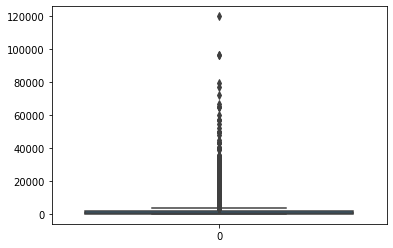

In [69]:
sns.boxplot(data=df['VALOR_REEMBOLSADO'])

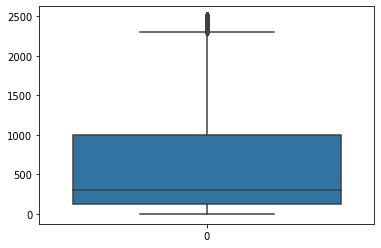

In [70]:
df_tratado = df[df['VALOR_REEMBOLSADO']<=2500]
sns.boxplot(data=df_tratado['VALOR_REEMBOLSADO'])

#### Top 10 senadores que mais declararam despesas

In [71]:
df_senador_top10 = df.groupby('SENADOR')['VALOR_REEMBOLSADO'].sum().sort_values(ascending=[False])[:10].reset_index()

In [72]:
fig = px.bar(df_senador_top10, x='SENADOR',y='VALOR_REEMBOLSADO', 
             title="Top 10 senadores com mais gastos - 2019-2022",
            width=600, height=400)
fig.update_xaxes(tickangle=45)
fig.show()

Senador Rogerio Carvalho possui os maiores valores reembolsados entre 2019 a 2022. Vamos conferir seus maiores gastos?

In [73]:
df_maior_gasto = df[df['SENADOR']=='ROGERIO CARVALHO'].reset_index()

In [74]:
df_maior_gasto.shape[0]

970

In [75]:
df_sen_maior_gasto = df_maior_gasto.groupby('TIPO_DESPESA_TRATADO')['VALOR_REEMBOLSADO'].sum().reset_index()

In [76]:
fig = px.bar(df_sen_maior_gasto, y='VALOR_REEMBOLSADO', x='TIPO_DESPESA_TRATADO', text_auto='.2s',
            title="Valores Reembolsados - Senador Rogerio Carvalho")
fig.show()

O maior gasto do Rogerio Carvalho foi com Locomoção, hospedagem, alimentação, combustíveis ou lubrificantes, somente neste item o senador ao longo dos 4 anos gastou mais de 400 mil. Vamos olhar como foi o gasto anual e mensal para este item.

In [77]:
df_maior_desp = df_maior_gasto[df_maior_gasto['TIPO_DESPESA_TRATADO']=='Locomocao']

In [78]:
df_maior_desp_mes = df_maior_desp.groupby(['ANO','MES'])['VALOR_REEMBOLSADO'].sum().reset_index()

In [79]:
fig = px.bar(df_maior_desp_mes, y='VALOR_REEMBOLSADO', x='MES',color="ANO", text_auto='.2s',
            title="Valores Mensais Reembolsados - Senador Rogerio Carvalho",
             barmode='group',
             height=400)
fig.show()

Quando olhamos os valores acumulados por ano, podemos ver que o senador possui muita discrepâncias nas utilizações.

#### Quem mais gastou em 2022?

Para termos uma visão mais recente, agora vamos avaliar somente os gastos referentes a 2022 dos senadores.

In [80]:
df_gastos_2022 = df.groupby(['ANO','SENADOR'])['VALOR_REEMBOLSADO'].sum().sort_values(ascending=[False]).reset_index()
df_top10_2022 = df_gastos_2022[df_gastos_2022['ANO']==2022][:10]

In [81]:
fig = px.bar(df_top10_2022, x='SENADOR',y='VALOR_REEMBOLSADO', 
             title="Top 10 senadores com mais gastos - 2022",
            width=600, height=400)
fig.update_xaxes(tickangle=45)
fig.show()

O maior gasto em 2022 foi para o senador Chico Rodrigues, vamos avaliar quais os tipos de gastos que ele realizou.

In [82]:
df_maior_gasto_2022 = df[(df['SENADOR']=='CHICO RODRIGUES') & (df['ANO']==2022)].reset_index()
df_sen_maior_gasto_2022 = df_maior_gasto_2022.groupby('TIPO_DESPESA_TRATADO')['VALOR_REEMBOLSADO'].sum().reset_index()

In [83]:
df_maior_gasto_2022.shape[0]

33

In [84]:
fig = px.bar(df_sen_maior_gasto_2022, y='VALOR_REEMBOLSADO', x='TIPO_DESPESA_TRATADO', text_auto='.2s',
            title="Valores Reembolsados 2022- Senador Chico Rodrigues")
fig.show()

O senador Chico Rodrigues teve o maior gasto no 1º trimestre de 2022 com divulgação das atividades, vamos visualizar quais foram os fornecedores que mais prestadoram serviços para o senador.

In [85]:
df_maior_desp_2022 = df_maior_gasto_2022[df_maior_gasto_2022['TIPO_DESPESA_TRATADO']=='Divulgacao Atividade']

In [86]:
df_maior_desp_chico_rodrigues = df_maior_desp_2022.groupby('DETALHAMENTO')['VALOR_REEMBOLSADO'].sum().reset_index()

In [87]:
fig = px.bar(df_maior_desp_chico_rodrigues, y='VALOR_REEMBOLSADO', x='DETALHAMENTO', text_auto='.2s',
            title="Detalhamento Valores Reembolsados - Senador Chico Rodrigues")
fig.show()

Como podemos ver na figura acima, dos 69k reembolsados não houve detalhamento informando o motivo do uso.

#### Vamos comparar os gastos do senador que mais gastou com o que menos gastou

In [88]:
df_gastos_2022[df_gastos_2022['ANO']==2022][-1:]

,ANO,SENADOR,VALOR_REEMBOLSADO
372,2022,STYVENSON VALENTIM,5713.03


In [89]:
df_maior_menor_gasto = df[((df['SENADOR']=='CHICO RODRIGUES') | 
                               (df['SENADOR']=='STYVENSON VALENTIM'))
                               & (df['ANO']==2022)].reset_index()

In [90]:
df_sen_maior_menor_gasto_2022 = df_maior_menor_gasto.groupby(['SENADOR','TIPO_DESPESA_TRATADO'])['VALOR_REEMBOLSADO'].sum().reset_index()

In [91]:
fig = px.bar(df_sen_maior_menor_gasto_2022, y='VALOR_REEMBOLSADO', x='TIPO_DESPESA_TRATADO',color="SENADOR", text_auto='.2s',
            title="Valor reembolsado x Tipo de despesa (Senador maior e menor gasto)",
             barmode='group',
             height=400)
fig.show()

#### Quais foram os partidos que mais tiveram gastos?

In [92]:
df_partido_top10 = df.groupby('Partido')['VALOR_REEMBOLSADO'].sum().sort_values(ascending=[False])[:10].reset_index()

In [93]:
fig = px.bar(df_partido_top10, x='Partido',y='VALOR_REEMBOLSADO', 
             title="Top 10 partidos com mais gastos - 2019-2022",
             text_auto='.2s',
            width=600, height=400)
fig.update_traces(marker_color='blue')
fig.show()

In [162]:
df_agg = df.groupby(['ANO','Partido']).agg({'VALOR_REEMBOLSADO':'sum','SENADOR':lambda x: x.nunique()}).reset_index()
df_partidos_2022 = df_agg.sort_values('VALOR_REEMBOLSADO', ascending=False)
df_partidos_2022 = df_partidos_2022[df_partidos_2022['ANO']==2022][:10]

In [164]:
fig = px.bar(df_partidos_2022, x='Partido',y='VALOR_REEMBOLSADO', 
             title="Top 10 partido com mais gastos - 2022",
             text_auto='.2s',
             text="SENADOR",
            width=600, height=400)
fig.show()

Analisando os gastos dos partidos ao qual os enadores pertencem, verifiquei que o partido "PSD" possui 12 senadores e no primeiro trimestre de 2022 solicitou ~1MM de reembolso, quando verifiquei o partido MDB que está em segundo no ranking, este possui 13 senadores ativos e teve um gasto inferior de 200k em relação ao primeiro com mais gastos.

#### Qual o gasto por ano?

In [99]:
df_gasto_ano = df.groupby('ANO')['VALOR_REEMBOLSADO'].sum().sort_values(ascending=[False])[:10].reset_index()

In [100]:
fig = px.bar(df_gasto_ano, x='ANO',y='VALOR_REEMBOLSADO', 
             title="Gastos por ano - 2019-2022",
            width=600, height=400)
fig.update_traces(marker_color='green') 
fig.show()

#### Gasto por mês

In [101]:
df_filter = df[df['DATA_MES'] >= '2019-01'].reset_index()
reembolso_mes = df_filter.groupby(by='DATA_MES').VALOR_REEMBOLSADO.sum().reset_index()

In [102]:
reembolso_mes.head()

,DATA_MES,VALOR_REEMBOLSADO
0,2019-01,1479757.87
1,2019-02,1617660.69
2,2019-03,1885766.92
3,2019-04,2014987.01
4,2019-05,2299315.89


In [103]:
fig=px.scatter(reembolso_mes, x='DATA_MES',
            y='VALOR_REEMBOLSADO',
               title="Gastos mensal - 2019-2022",
            width=600, height=400)
fig.add_hline(y=reembolso_mes['VALOR_REEMBOLSADO'].mean(), 
              line_color="red",
             line_dash="dot",
             annotation_text="Média dos Gastos",
             annotation_position="bottom right")
fig.show()

#### Criando a feature com o tipo de gasto realizado

In [104]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [105]:
text = " ".join(s.lower() for s in df['DETALHAMENTO'])

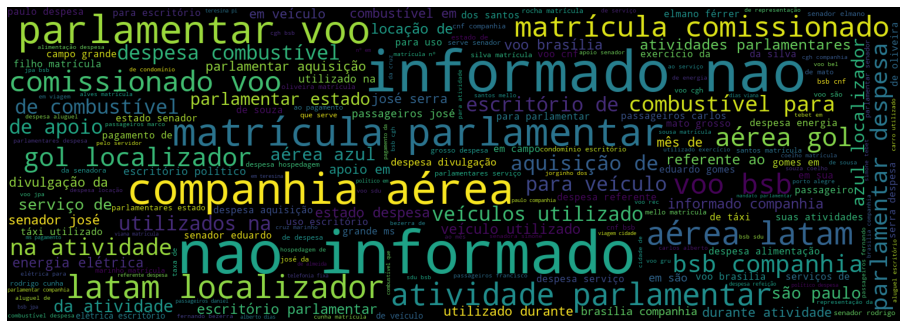

In [106]:
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(text)
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Visão dos gastos a partir do estado de cada senador

In [107]:
from geopy.geocoders import Nominatim

In [108]:
import folium

In [109]:
lat = df['LATITUDE']
log = df['LONGITUDE']

## Forecasting

In [106]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

from sklearn.metrics import mean_squared_error
from math import sqrt

Optei por fazer a previsão olhando somente os senadores que estão ativos

In [107]:
df_1 = df_tratado[(df_tratado['Ativo']=='Sim') & ((df_tratado['DATA_MES']>='2019-01') & (df_tratado['DATA_MES']<='2022-04'))]

In [108]:
df_1.shape[0]

43784

In [109]:
df_1.shape[0]

43784

In [110]:
#pega a quantidade de linhas e retira 30% (15k são ~30% do universo de 56k)
split_point = len(df_1)-15000

In [111]:
#define que a variavel df_model vai conter linhas até o split point
df_model = df_1[0:split_point]

In [112]:
#define que a variavel validation terá os dados do split_point em diante
validation = df_1[split_point:]

In [113]:
#imprime o tamanho dos conjuntos
print('Dataset %d, Validation %d' % (len(df_model), len(validation)))

Dataset 28784, Validation 15000


In [114]:
df_model.head(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,...,DATA_MES,Partido,UF,Ativo,COD_UF,ESTADO,LATITUDE,LONGITUDE,REGIAO,TIPO_DESPESA_TRATADO
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582758,2019-01-04,Despesa com pagamento de energia elétrica do e...,66.02,...,2019-01,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte,Aluguel de Imoveis


In [115]:
#necessário alterar o nome das colunas para 'ds' tipo de data para o modelo e y que pode ser a soma de vendas por exemplo
df_model = df_model[['DATA', 'VALOR_REEMBOLSADO']].rename(columns = {'DATA': 'ds', 'VALOR_REEMBOLSADO': 'y'})
validation = validation[['DATA', 'VALOR_REEMBOLSADO']].rename(columns = {'DATA': 'ds', 'VALOR_REEMBOLSADO': 'y'})

In [116]:
#dataset validation
df_validation = pd.DataFrame({'ds': validation['ds']})

In [117]:
#instacia o objeto prophet
model = Prophet()

In [118]:
#gerando o modelo
model.fit(df_model)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [119]:
#aplicando o modelo prophet
saida = model.predict(df_validation)

In [120]:
#imprime as saidas
saida[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-04,387.954732,-405.460476,1190.073617
1,2020-01-08,558.976661,-247.649312,1341.457149
2,2020-01-09,535.709721,-256.054001,1326.862928
3,2020-01-18,429.692501,-379.983411,1249.848006
4,2020-01-19,451.864942,-392.371687,1252.960878
...,...,...,...,...
14995,2022-04-05,740.577415,-99.368180,1505.109747
14996,2022-04-06,754.955145,-129.414216,1550.445364
14997,2022-04-06,754.955145,-121.561994,1545.704415
14998,2022-04-06,754.955145,-37.308237,1561.317466


In [121]:
validation

,ds,y
37778,2021-09-21,102.70
37780,2021-10-30,108.77
37781,2021-09-27,24.00
37782,2021-09-21,170.83
37783,2021-09-22,270.80
...,...,...
56108,2022-04-02,1361.66
56109,2022-04-02,1361.66
56111,2022-04-04,1681.23
56112,2022-04-06,1663.61


In [122]:
#Avaliando os resultados
#O RMSE quer dizer que o modelo na previsão que ele faz pode errar 3k pra cima ou pra baixo
rmse = sqrt(mean_squared_error(validation['y'], saida.yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 687.876


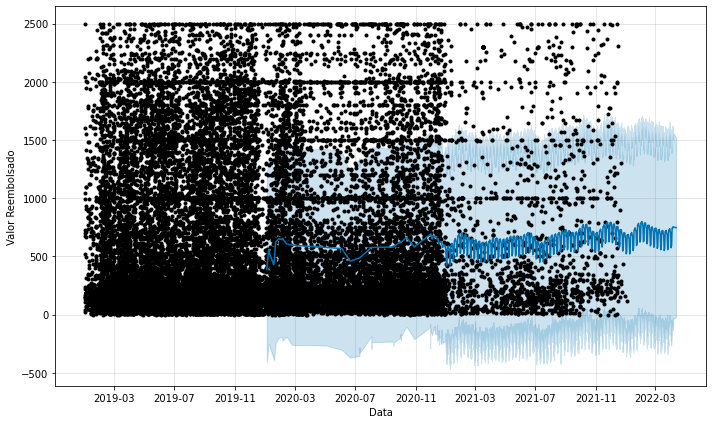

In [123]:
figura = model.plot(saida, xlabel = 'Data', ylabel = 'Valor Reembolsado');

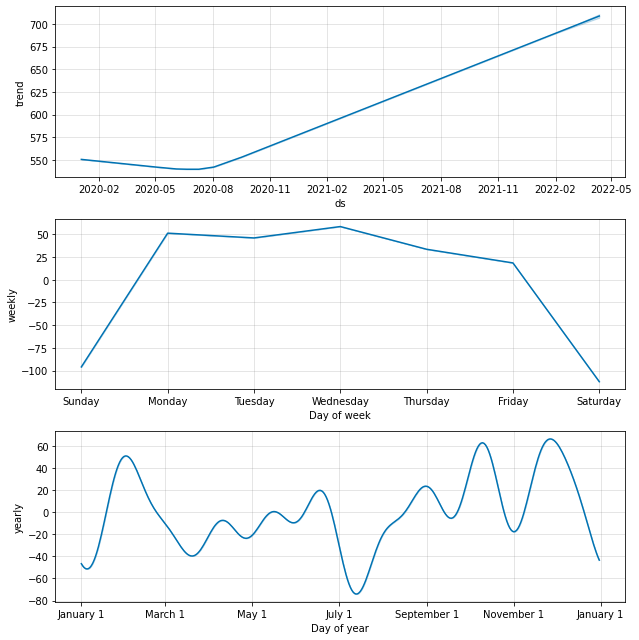

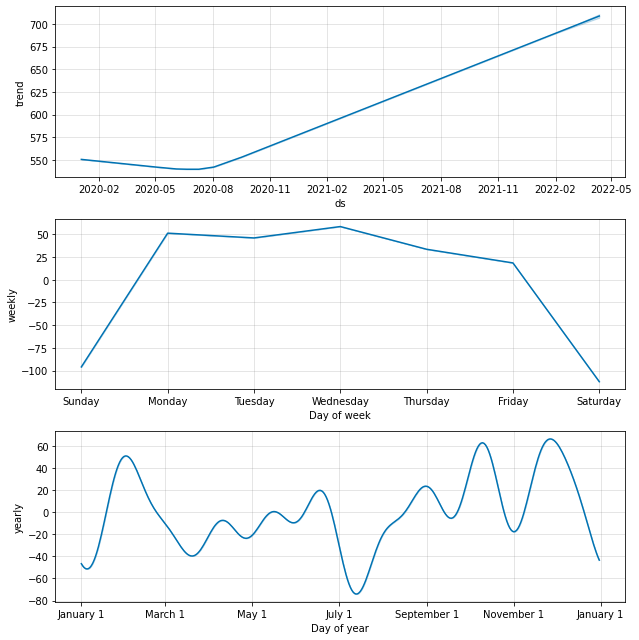

In [124]:
model.plot_components(saida)

In [125]:
#Após treinar e validar o modelo, foi gerado uma previsão das vendas para os próximos anos
future = model.make_future_dataframe(periods=5, freq='M')  
forecast = model.predict(future)

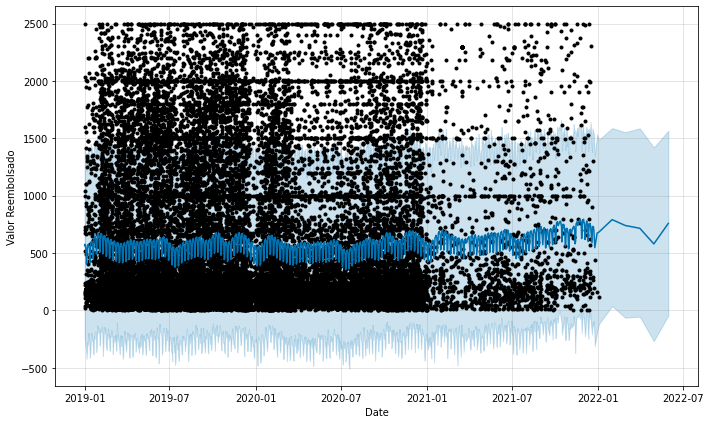

In [126]:
#Plotando a previsão
model.plot(forecast, xlabel = 'Date', ylabel = 'Valor Reembolsado');

In [127]:
df.head()

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,...,DATA_MES,Partido,UF,Ativo,COD_UF,ESTADO,LATITUDE,LONGITUDE,REGIAO,TIPO_DESPESA_TRATADO
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582758,2019-01-04,Despesa com pagamento de energia elétrica do e...,66.02,...,2019-01,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte,Aluguel de Imoveis
1,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,6582755,2019-01-04,Despesa com pagamento de energia elétrica do e...,139.98,...,2019-01,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte,Aluguel de Imoveis
2,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,119,2019-01-07,Despesa com pagamento de aluguel de imóvel par...,6000.00,...,2019-01,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte,Aluguel de Imoveis
4,2019,2,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,7236036,2019-02-04,Despesa com pagamento de energia elétrica para...,99.45,...,2019-02,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte,Aluguel de Imoveis
5,2019,2,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,7236031,2019-02-04,Despesa com pagamento de energia elétrica para...,262.93,...,2019-02,PDT,RO,Sim,11,Rondônia,-10.83,-63.34,Norte,Aluguel de Imoveis
